# Project: Telecom Customer Churn Prediction

**Project Introduction**

Telecom companies often lose customers due to issues like poor service, high prices, or better deals from competitors. To reduce this churn, it's important to identify which customers are likely to leave. This project aims to build a machine learning model that predicts customer churn using data such as demographics, service usage, and billing information. With this model, telecom companies can take early action to keep their customers and improve retention.

**Project Updates**

In regards to updates to the scope of our project, we haven't had any changes. The goal is to still utilize MLM models (Logistic Regression, Decision Tree, Random Forest) to predict customer churn within our dataset. However, there are certain elements we are struggling with that we weren't aware of before. They are the following:

* Imbalanced Classes: We are noticing that our dataset has imbalanced classes. This means that the number of non-churning customers is a lot higher than the opposite. To work around this, we are going to adjust the class weighting to penalize the model more for misclassifying the minority class

* Feature Importance: We want to ensure proper interpretation of feature importance. This is to make sure we avoid overlooking any key factors that affect churn. For our tree-based models, we are extracting feature important score directly.

#Link to the Github Repo:  https://github.com/ufiyan/CS418-Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation and Preprocessing

**Step 1:**
Data Collection and Preprocessing using the Telco Customer Churn Dataset.

Steps includes:
Loaing Dataset,
Handling missing values,
Exploring features,
Normalizing numerical features,
EDA


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
for f in os.listdir('/content'):
    print(f)


.config
drive
WA_Fn-UseC_-Telco-Customer-Churn.csv
sample_data


In [ ]:
# Step 1: Load the dataset
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(file_path)

 Provides a summary of the dataset, including column data types, non-null counts, and the number of missing values for each column.

In [ ]:
# Step 2: Inspect the dataset
print("Dataset 1: Overview:")
print(df.info())
print("\nDataset 1: Missing values per column:")
print(df.isnull().sum())


Dataset 1: Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

In [ ]:
# Print the column names of your dataframe to verify the correct name
print(df.columns)



Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


Converts the TotalCharges column to numeric values, handling any non-numeric values (e.g., empty strings) by coercing them into NaN. If there are missing values, they are replaced with the column's median.

In [ ]:
# Handle `TotalCharges`
# Convert to numeric and handle non-numeric rows
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
if df['TotalCharges'].isnull().sum() > 0:
    print("\nMissing `TotalCharges` detected, filling with median.")
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())




Missing `TotalCharges` detected, filling with median.


Converts binary categorical features (e.g., "Yes"/"No") to numerical values (1/0).

In [ ]:
# Step 4: Encode categorical variables
# Binary features (Yes/No) already encoded as 1/0. Confirm they are correctly mapped.
binary_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for feature in binary_features:
    if feature in df.columns:
        # Handle missing values (NaN) before mapping
        df[feature] = df[feature].fillna('No')  # Replace NaNs with 'No' (or 'Yes', depending on context)
        df[feature] = df[feature].map({'Yes': 1, 'No': 0})
    else:
        print(f"Skipping binary encoding for missing feature: {feature}")




 Filters out the already one-hot encoded columns and prints the ones that have been processed.

In [ ]:
# Step 5: Skip encoding categorical_features because one-hot encoding is already applied
print("\nThe following categorical features are already encoded and reflected in the DataFrame:")
categorical_features = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                        'StreamingMovies', 'Contract', 'PaymentMethod']
# Filter already one-hot encoded features
encoded_columns = [col for col in df.columns if any(feature.lower() in col.lower() for feature in categorical_features)]
print(encoded_columns)


The following categorical features are already encoded and reflected in the DataFrame:
['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


Normalizes the numerical features (e.g., tenure, MonthlyCharges, TotalCharges) by scaling them to have a mean of 0 and standard deviation of 1.

In [ ]:
# Step 6: Normalize numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Exploratory Data Analysis

**Dataset 1 Teclo Customer Churn EDA**


Outputs summary statistics for all numerical features, including count, mean, standard deviation, and percentiles.

In [ ]:
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
       SeniorCitizen      Partner   Dependents        tenure  PhoneService  \
count    7043.000000  7043.000000  7043.000000  7.043000e+03   7043.000000   
mean        0.162147     0.483033     0.299588 -2.421273e-17      0.903166   
std         0.368612     0.499748     0.458110  1.000071e+00      0.295752   
min         0.000000     0.000000     0.000000 -1.318165e+00      0.000000   
25%         0.000000     0.000000     0.000000 -9.516817e-01      1.000000   
50%         0.000000     0.000000     0.000000 -1.372744e-01      1.000000   
75%         0.000000     1.000000     1.000000  9.214551e-01      1.000000   
max         1.000000     1.000000     1.000000  1.613701e+00      1.000000   

       PaperlessBilling  MonthlyCharges  TotalCharges        Churn  
count       7043.000000    7.043000e+03  7.043000e+03  7043.000000  
mean           0.592219   -6.406285e-17 -1.488074e-17     0.265370  
std            0.491457    1.000071e+00  1.000071e+00     0.441561  


Plots a bar chart showing the distribution of the target variable (Churn), which indicates how many customers churned vs. those who didn’t. We can see a clear majority of customers that Churn (1) and those that Don't Churn (0).

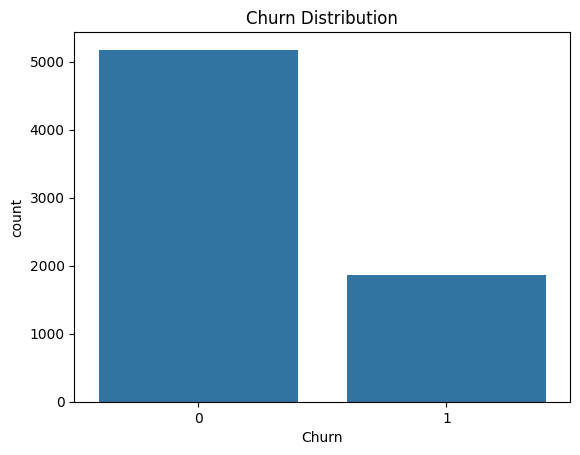

In [ ]:
# Visualization: Distribution of target variable
###
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

**Stacked Bar Chart for Categorical Variables**


This helps visualize the relationship between churn and different categorical features like Contract, PaymentMethod, etc.

1. Contract Type

**Work By Sohaib Ghani**

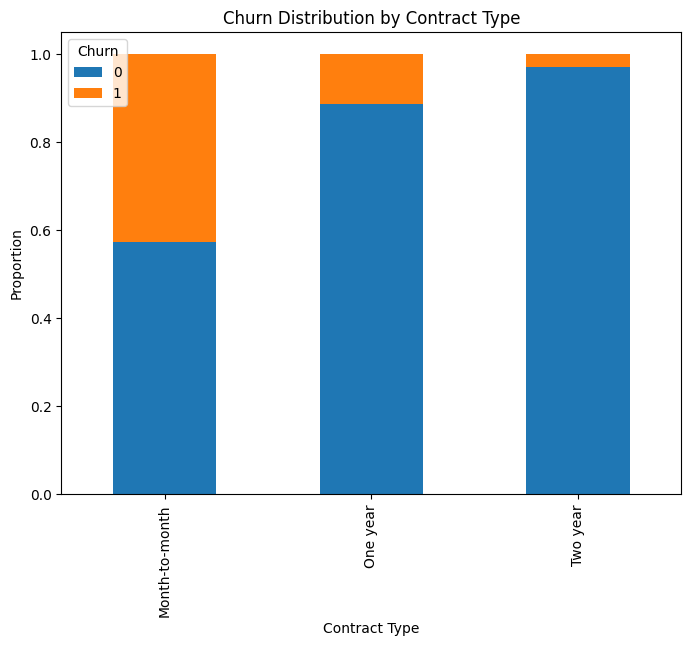

In [ ]:
# Stacked bar chart for Contract type vs Churn   Sohaib Ghani

contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')
contract_churn.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Distribution by Contract Type')
plt.ylabel('Proportion')
plt.xlabel('Contract Type')
plt.show()


2. Payment Type

**Work By SOhaib Ghani**

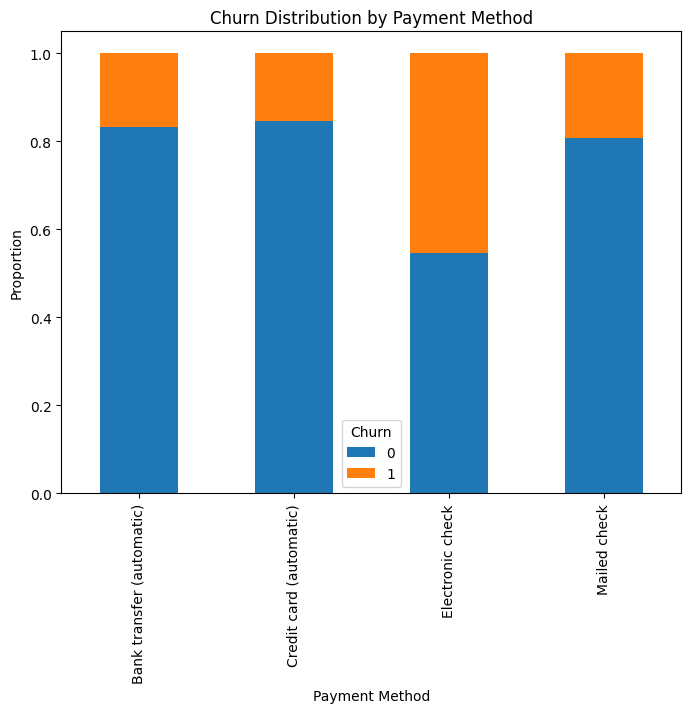

In [ ]:
# Stacked bar chart for PaymentMethod vs Churn  (Sohaib Ghani)


payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index')
payment_churn.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Distribution by Payment Method')
plt.ylabel('Proportion')
plt.xlabel('Payment Method')
plt.show()

In [ ]:
# Enhanced EDA Visualizations - CS418 Project

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Normalize numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


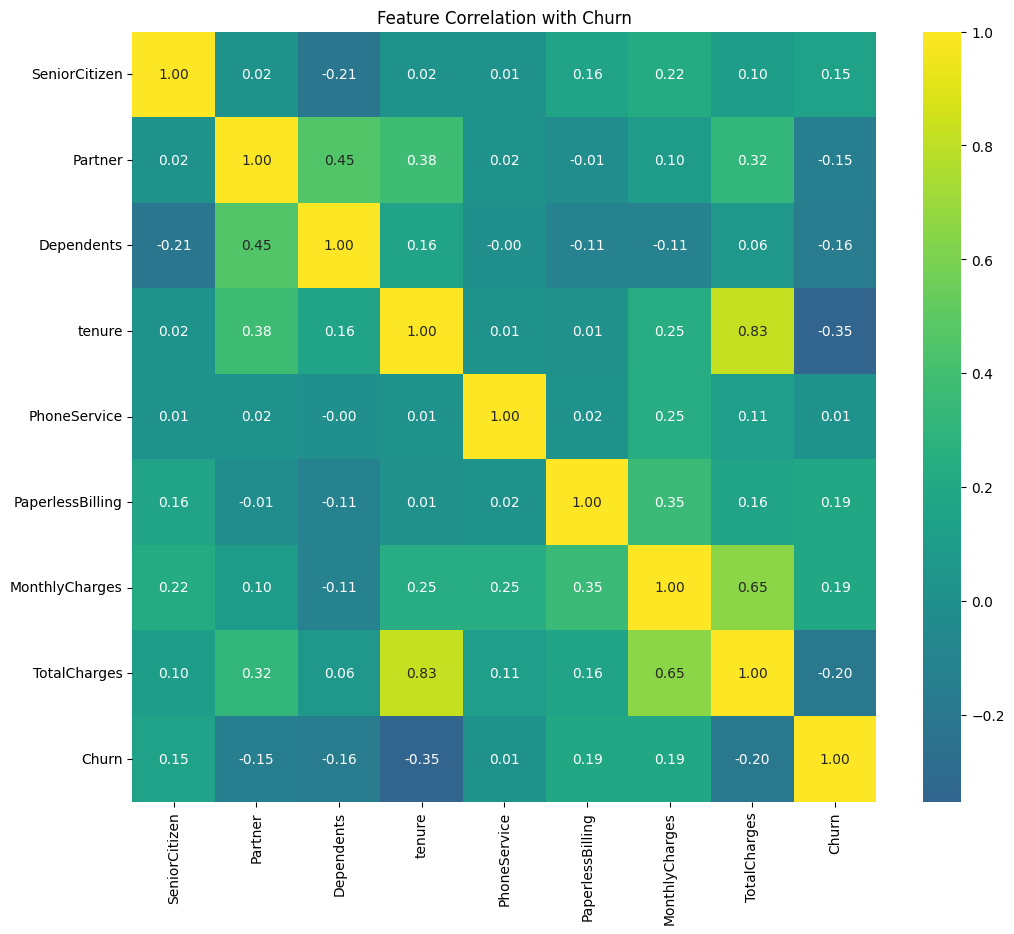

In [ ]:
# 5. Annotated Correlation Matrix
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', center=0)
plt.title('Feature Correlation with Churn')
plt.show()



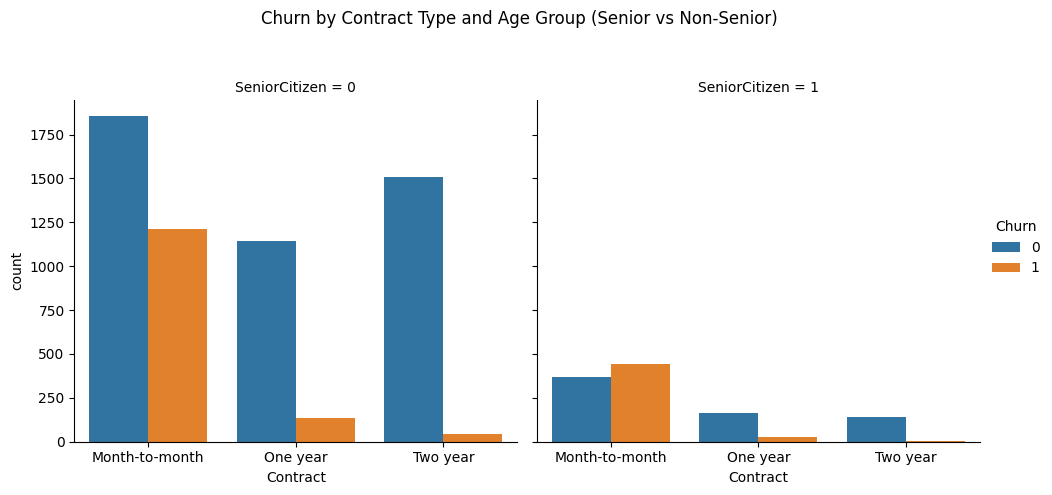

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Grouped barplot: Contract vs Churn grouped by SeniorCitizen
sns.catplot(
    data=df,
    x="Contract",
    hue="Churn",
    col="SeniorCitizen",
    kind="count",
    height=5, aspect=1
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Churn by Contract Type and Age Group (Senior vs Non-Senior)")
plt.show()


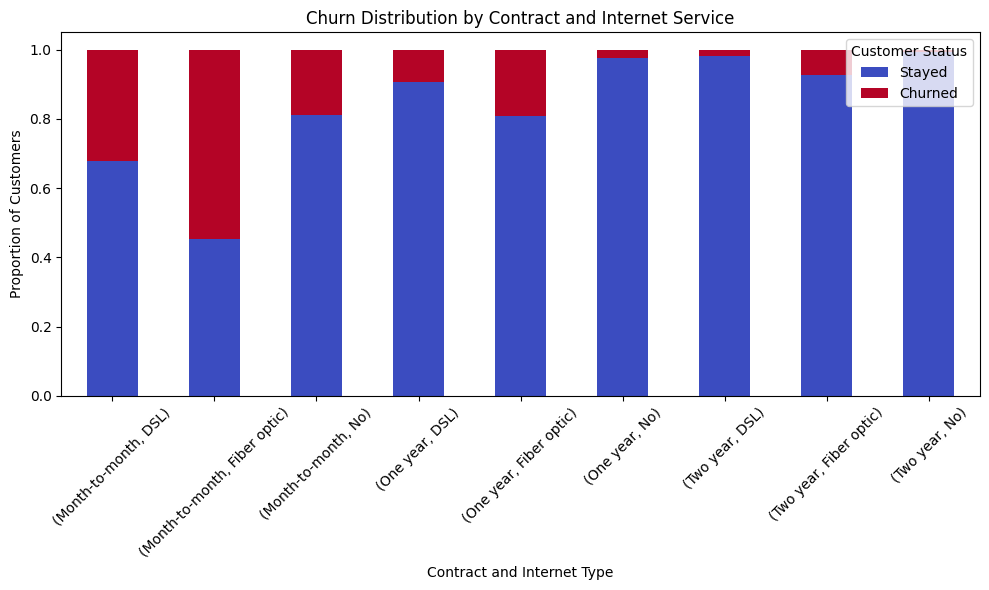

In [ ]:
# Create grouped churn counts
stacked_data = pd.crosstab(
    index=[df['Contract'], df['InternetService']],
    columns=df['Churn'],
    normalize='index'
).rename(columns={0: 'Stayed', 1: 'Churned'})

# Plot
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title("Churn Distribution by Contract and Internet Service")
plt.ylabel("Proportion of Customers")
plt.xlabel("Contract and Internet Type")
plt.xticks(rotation=45)
plt.legend(loc="upper right", title="Customer Status")
plt.tight_layout()
plt.show()


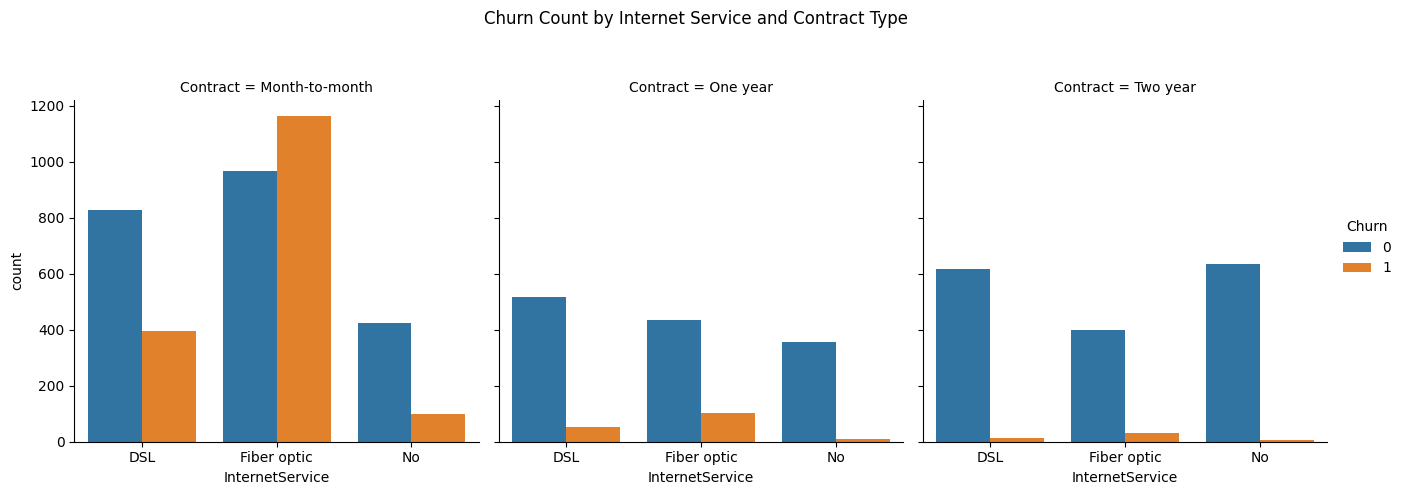

In [ ]:
sns.catplot(
    data=df,
    x="InternetService",
    hue="Churn",
    col="Contract",
    kind="count",
    height=5,
    aspect=0.9
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Churn Count by Internet Service and Contract Type")
plt.show()


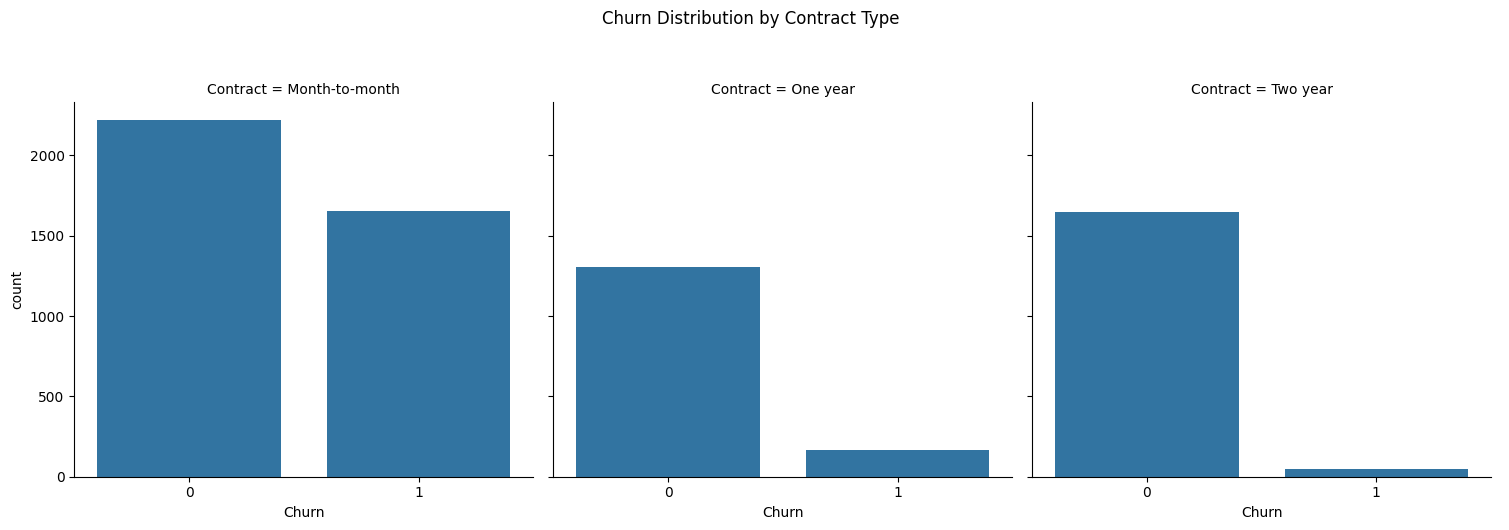

In [ ]:

# Facet grid by Contract type
g = sns.catplot(x="Churn", col="Contract", kind="count", data=df)
g.fig.suptitle("Churn Distribution by Contract Type", y=1.05)
plt.tight_layout()
plt.show()


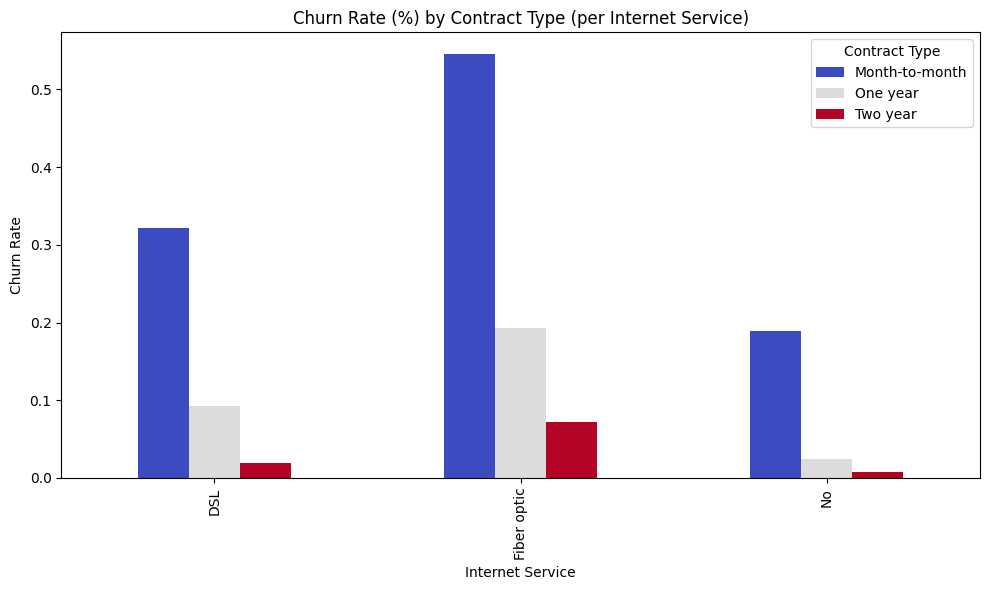

In [ ]:
# Create a new grouped DataFrame
grouped = df.groupby(['Contract', 'InternetService'])['Churn'].mean().unstack()

# Convert to percentages and plot as bar chart
grouped.T.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='coolwarm')
plt.title("Churn Rate (%) by Contract Type (per Internet Service)")
plt.ylabel("Churn Rate")
plt.xlabel("Internet Service")
plt.legend(title="Contract Type")
plt.tight_layout()
plt.show()


In [ ]:
# Add this before rendering your chart
#alt.data_transformers.disable_max_rows()

# Then render the chart
#chart

import pandas as pd
import altair as alt

# Load dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean and simplify relevant columns
binary_columns = ['Churn', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in binary_columns:
    df[col] = df[col].fillna('No')
    df[col] = df[col].map({'Yes': 'Yes', 'No': 'No', 'No internet service': 'No', 'No phone service': 'No'})

# Reshape data for faceted bar charts
melted_df = df.melt(id_vars=['Churn'],
                    value_vars=['StreamingTV', 'StreamingMovies', 'MultipleLines'],
                    var_name='Service',
                    value_name='Subscription')

# Allow large dataset
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')

# Larger interactive chart with tooltip
chart = alt.Chart(melted_df).mark_bar().encode(
    x=alt.X('Subscription:N', title='Subscription Status'),
    y=alt.Y('count()', title='Customer Count'),
    color=alt.Color('Churn:N', title='Churn'),
    tooltip=['Churn:N', 'Subscription:N', 'count()'],
    column=alt.Column('Service:N', title='Service Type')
).properties(
    title='Churn Distribution by Streaming and Phone Services',
    width=200,   # Width of each subplot
    height=300   # Height of each subplot
).interactive()

chart




alt.Chart(...)

In [ ]:
# 2) Ensure TotalCharges is numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3) Average MonthlyCharges and TotalCharges by churn status
avg_charges_by_churn = (
    df
    .groupby('Churn')[['MonthlyCharges', 'TotalCharges']]
    .mean()
    .rename(index={'No':'Stayed','Yes':'Churned'})
)
print("Average Charges by Churn Status:")
print(avg_charges_by_churn)

# 4) For churned customers only: average charges by Contract type
avg_churned_by_contract = (
    df[df['Churn']=='Yes']
    .groupby('Contract')[['MonthlyCharges', 'TotalCharges']]
    .mean()
)
print("\nAverage Charges for Churned Customers by Contract:")
print(avg_churned_by_contract)

# 5) (Optional) Example: average charges by InternetService
avg_by_internet = (
    df
    .groupby('InternetService')[['MonthlyCharges', 'TotalCharges']]
    .mean()
)
print("\nAverage Charges by Internet Service:")
print(avg_by_internet)

Average Charges by Churn Status:
         MonthlyCharges  TotalCharges
Churn                                
Stayed        61.265124   2555.344141
Churned       74.441332   1531.796094

Average Charges for Churned Customers by Contract:
                MonthlyCharges  TotalCharges
Contract                                    
Month-to-month       73.019396   1164.460574
One year             85.050904   4066.212048
Two year             86.777083   5432.363542

Average Charges by Internet Service:
                 MonthlyCharges  TotalCharges
InternetService                              
DSL                   58.102169   2119.789259
Fiber optic           91.500129   3205.304570
No                    21.079194    665.220329


# Hypothesis

**Overview: General Hypothesis: The likelihood of a customer churning is influenced by a combination of demographic, service-related, and account-specific factors such as tenure, contract type, monthly charges, and service subscriptions.**


**Hypothesis 1: Influence of Having a Partner or Dependents on Churn
Hypothesis: Customers with a partner or dependents are less likely to churn.**

**Reasoning: Family-oriented customers may value stability and reliability in services, making them more likely to stay with their current provider.**


**Work by Daniyal Siddiqui & Sufiyan Syed**

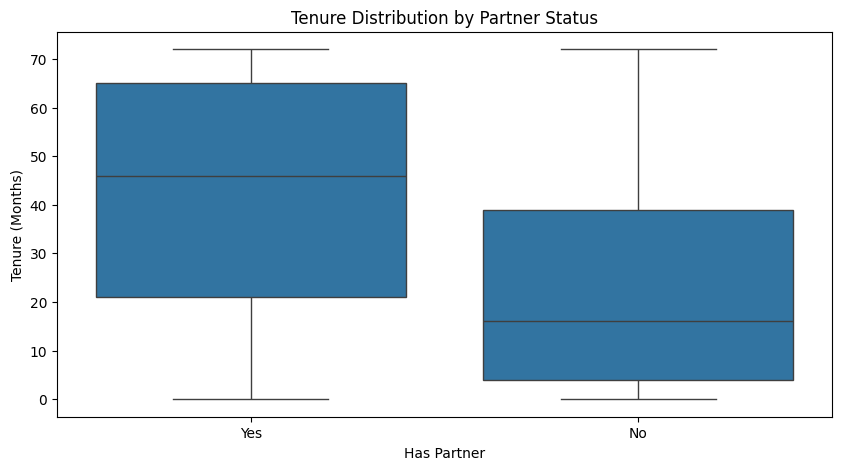

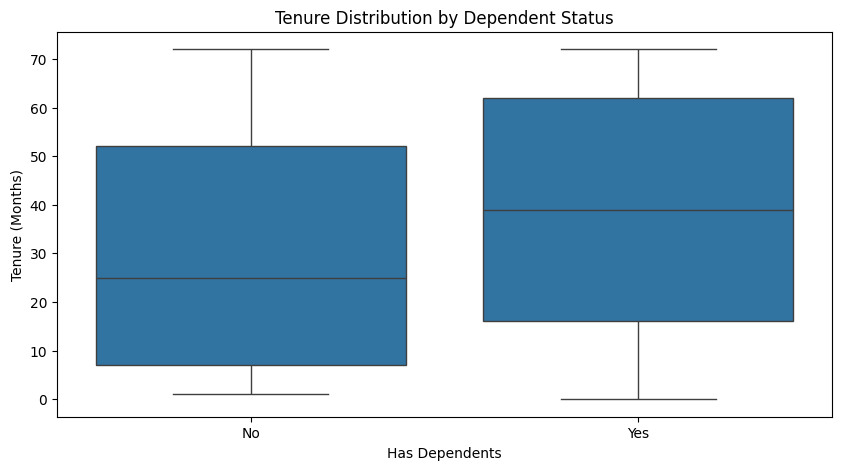

Chi-Squared Test p-value for Partner: 2.1399113440759935e-36
Chi-Squared Test p-value for Dependents: 4.9249216612154196e-43


In [ ]:
from scipy.stats import chi2_contingency

# Hypothesis 1: Partner and Dependents on Churn

# Boxplot showing Tenure vs Churn based on Partner (Daniyal Siddiqui)
plt.figure(figsize=(10, 5))
sns.boxplot(x='Partner', y='tenure', data=df)
plt.title('Tenure Distribution by Partner Status')
plt.xlabel('Has Partner')
plt.ylabel('Tenure (Months)')
plt.show()

# Boxplot showing Tenure vs Churn based on Dependents (Daniyal Siddiqui)
plt.figure(figsize=(10, 5))
sns.boxplot(x='Dependents', y='tenure', data=df)
plt.title('Tenure Distribution by Dependent Status')
plt.xlabel('Has Dependents')
plt.ylabel('Tenure (Months)')
plt.show()

# Perform Chi-Squared test for Partner and Churn relationship (Sufiyan Syed)
partner_churn_data = pd.crosstab(df['Partner'], df['Churn'])
chi2_partner, p_partner, dof_partner, expected_partner = chi2_contingency(partner_churn_data)
print(f"Chi-Squared Test p-value for Partner: {p_partner}")

# Perform Chi-Squared test for Dependents and Churn relationship  (Sufiyan Syed)
dependents_churn_data = pd.crosstab(df['Dependents'], df['Churn'])
chi2_dependents, p_dependents, dof_dependents, expected_dependents = chi2_contingency(dependents_churn_data)
print(f"Chi-Squared Test p-value for Dependents: {p_dependents}")


**Specific Hypotheses to Test**

Each hypothesis will focus on different variables in our dataset and their potential correlation with churn.

**Hypothesis 2: Impact of Contract Type on Churn
Hypothesis: Customers with Month-to-Month contracts are more likely to churn than customers with One-Year or Two-Year contracts.**

**Reasoning: Month-to-month contracts often indicate less commitment from the customer, so they might be more likely to leave if they find a better offer from a competitor.**

1. Impact of Contract Type on Churn
This hypothesis tests if customers with Month-to-Month contracts are more likely to churn than those with One-Year or Two-Year contracts.


**Work By Sufiyan Syed**

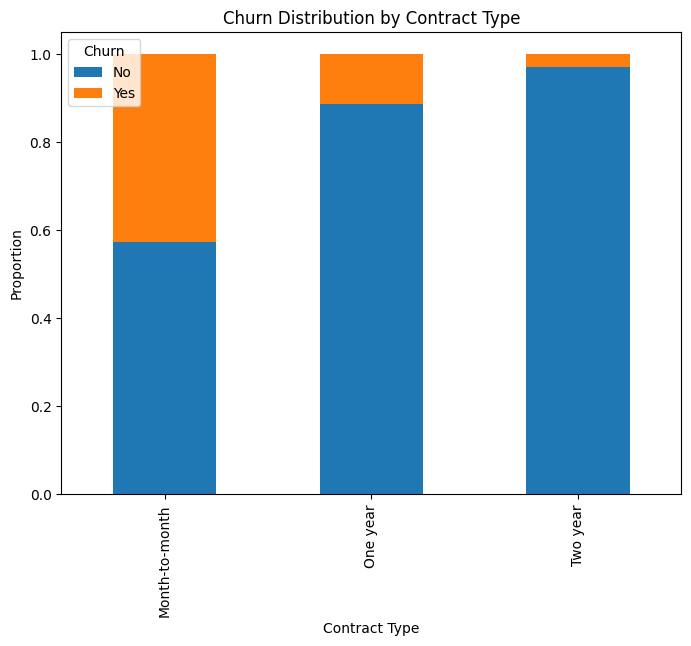

Chi-Squared Test p-value for contract type and churn: 5.863038300673391e-258


In [ ]:
# Hypothesis 2: Contract Type and Churn

# Plot a stacked bar chart showing churn distribution across contract types
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')
contract_churn.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Distribution by Contract Type')
plt.ylabel('Proportion')
plt.xlabel('Contract Type')
plt.show()

# Perform Chi-Squared test for statistical significance
from scipy.stats import chi2_contingency

contract_churn_data = pd.crosstab(df['Contract'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(contract_churn_data)
print(f"Chi-Squared Test p-value for contract type and churn: {p}")


**Hypothesis 3: Relationship Between Monthly Charges and Churn
Hypothesis: Customers with higher monthly charges are less likely to churn because they have a more significant financial commitment to the service.**

**Reasoning: Higher monthly charges may correlate with customers who have been with the company longer or have higher-value services.**


**Work By Sufiyan Syed**

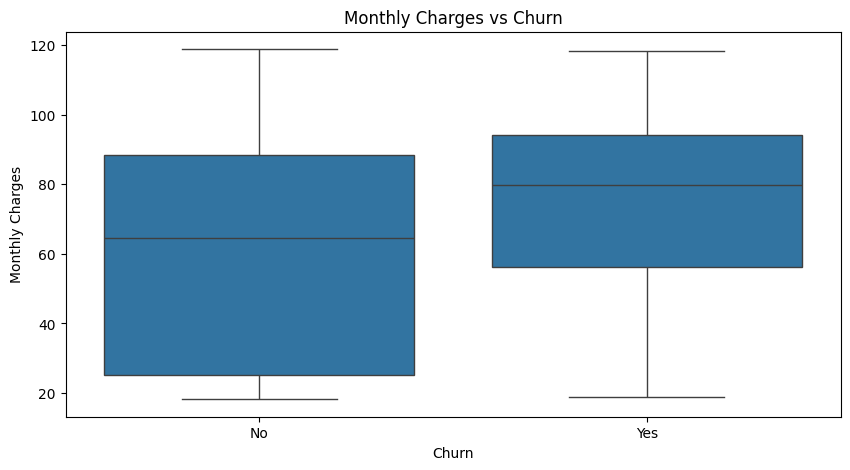

T-test p-value for monthly charges and churn: nan


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
# Hypothesis 3: Monthly Charges and Churn


# Boxplot showing Monthly Charges vs Churn
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()

# Perform t-test to compare monthly charges between churned and non-churned customers
from scipy.stats import ttest_ind

churned = df[df['Churn'] == 1]['MonthlyCharges']
non_churned = df[df['Churn'] == 0]['MonthlyCharges']

t_stat, p_value = ttest_ind(churned, non_churned)
print(f"T-test p-value for monthly charges and churn: {p_value}")


**Hypothesis 3: Tenure and Churn
Hypothesis: Customers with a longer tenure are less likely to churn compared to those with shorter tenures.**

**Reasoning: Longer-tenured customers may have developed a deeper relationship with the company, leading to lower churn rates.**

**Work By Sufiyan Syed**

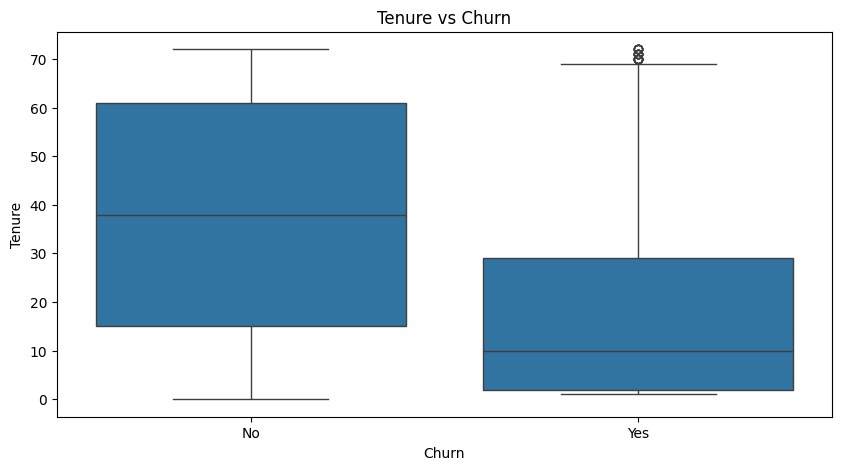

T-test p-value for Tenure: nan


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
# Hypothesis 4: Tenure and Churn
# Boxplot for Tenure vs Churn
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

# Perform t-test to compare tenure between churned and non-churned customers
tenure_churned = df[df['Churn'] == 1]['tenure']
tenure_non_churned = df[df['Churn'] == 0]['tenure']

t_stat_tenure, p_value_tenure = ttest_ind(tenure_churned, tenure_non_churned)
print(f"T-test p-value for Tenure: {p_value_tenure}")


**Hypothesis 5: The Role of Service Types (e.g., Internet, Tech Support) in Churn
Hypothesis: Customers who use services like Tech Support, Internet Service, and Online Backup are less likely to churn, as these services improve the perceived value of the offering.**

**Reasoning: Customers who use additional services may be more satisfied, which could reduce churn.**

**Work By Sufiyan Syed**

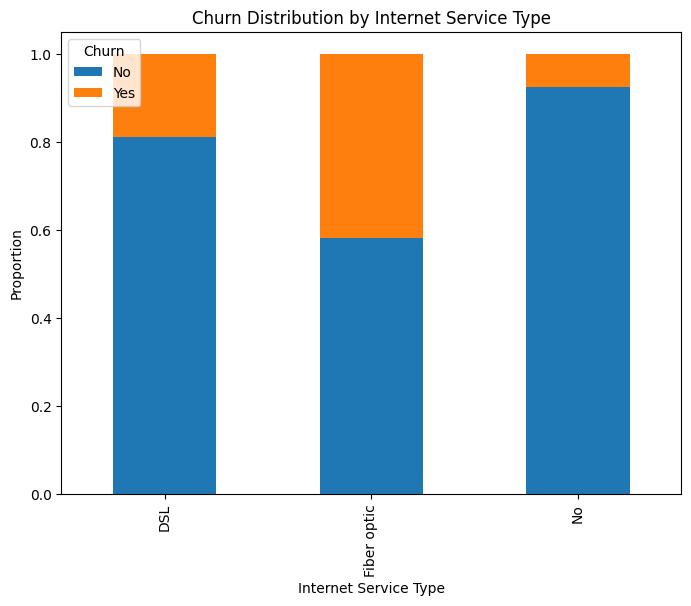

Chi-Squared Test p-value for Internet Service: 9.571788222840544e-160


In [ ]:
# Hypothesis 5: The Role of Service Types (e.g., Internet, Tech Support) in Churn
# Stacked bar chart showing churn distribution across Internet Service type
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index')
internet_churn.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Distribution by Internet Service Type')
plt.ylabel('Proportion')
plt.xlabel('Internet Service Type')
plt.show()

# Perform Chi-Squared test for Internet Service and Churn relationship
internet_churn_data = pd.crosstab(df['InternetService'], df['Churn'])
chi2_internet, p_internet, dof_internet, expected_internet = chi2_contingency(internet_churn_data)
print(f"Chi-Squared Test p-value for Internet Service: {p_internet}")


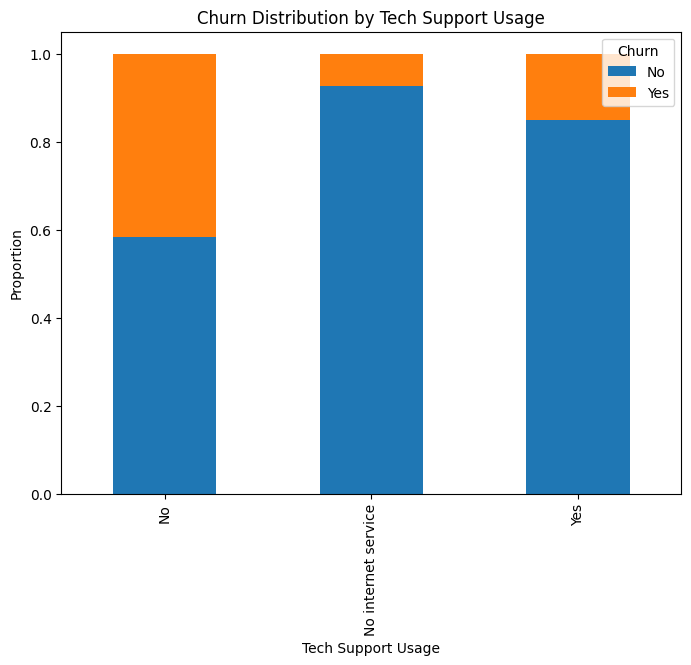

Chi-Squared Test p-value for Tech Support: 1.4430840279998987e-180


In [ ]:
# Stacked bar chart showing churn distribution across Tech Support usage
techsupport_churn = pd.crosstab(df['TechSupport'], df['Churn'], normalize='index')
techsupport_churn.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Churn Distribution by Tech Support Usage')
plt.ylabel('Proportion')
plt.xlabel('Tech Support Usage')
plt.show()


# Perform Chi-Squared test for Tech Support and Churn relationship
techsupport_churn_data = pd.crosstab(df['TechSupport'], df['Churn'])
chi2_techsupport, p_techsupport, dof_techsupport, expected_techsupport = chi2_contingency(techsupport_churn_data)
print(f"Chi-Squared Test p-value for Tech Support: {p_techsupport}")



**Conclusion and Analysis:**

**All the tests you performed show extremely low p-values, meaning that all the features tested (Partner, Dependents, Contract Type, Monthly Charges, Tenure, Internet Service, and Tech Support) significantly influence churn.**

**Based on the results of the statistical tests, we can confidently reject the null hypothesis for all the features we examined including contract type, tenure, monthly charges, internet service, tech support, partner status, and whether the customer has dependents. In each case, the p-values were extremely small (below 0.05), indicating that these variables have a statistically significant relationship with customer churn.**

# Machine Learning Analysis

This step involves training baseline machine learning models and evaluating their performance using various metrics. Below is the complete implementation in Python.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt


In [ ]:
# Define the feature set (X) and target variable (y)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

# Apply one‐hot encoding to categorical variables
X = pd.get_dummies(X, drop_first=True)

# --- FIX: fill missing values with column means before any split ---
X = X.fillna(X.mean())

# Re-split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:

print("New training set shape:", X_train.shape)

# --- FIX: scale features to help LogisticRegression converge ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Train Logistic Regression (max_iter increased)
logistic_model = LogisticRegression(max_iter=3000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on test data
y_pred_logistic       = logistic_model.predict(X_test)
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logistic))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_logistic))

New training set shape: (5634, 27)
Logistic Regression Performance:
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8415588106125191


Here, we are training one of our machine learning models. We are using the Logistic Regression model here (Daniyal Siddiqui)

Here, we are training one of our machine learning models. We are using the Decision Tree model here (Sohaib Ghani)

In [ ]:
# Train Decision Tree
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train, y_train)

# Predict on test data
y_pred_tree = tree_model.predict(X_test)
y_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]

# Evaluate Decision Tree model
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_tree))


Decision Tree Performance:
              precision    recall  f1-score   support

          No       0.84      0.83      0.83      1035
         Yes       0.54      0.55      0.54       374

    accuracy                           0.76      1409
   macro avg       0.69      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409

ROC-AUC: 0.7569195794259733


Here, we are training one of our machine learning models. We are using the Random Forest model here (Sufiyan Syed)

In [ ]:
# Train Random Forest
forest_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
forest_model.fit(X_train, y_train)

# Predict on test data
y_pred_forest = forest_model.predict(X_test)
y_pred_proba_forest = forest_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest))


Random Forest Performance:
              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1035
         Yes       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC-AUC: 0.841299181069002


We are plotting a ROC curve for all models. We can use this to evaluate the performance of our model by plotting the true positive rates against the false postiive rates. This will tell us how good our model is at binary classification.

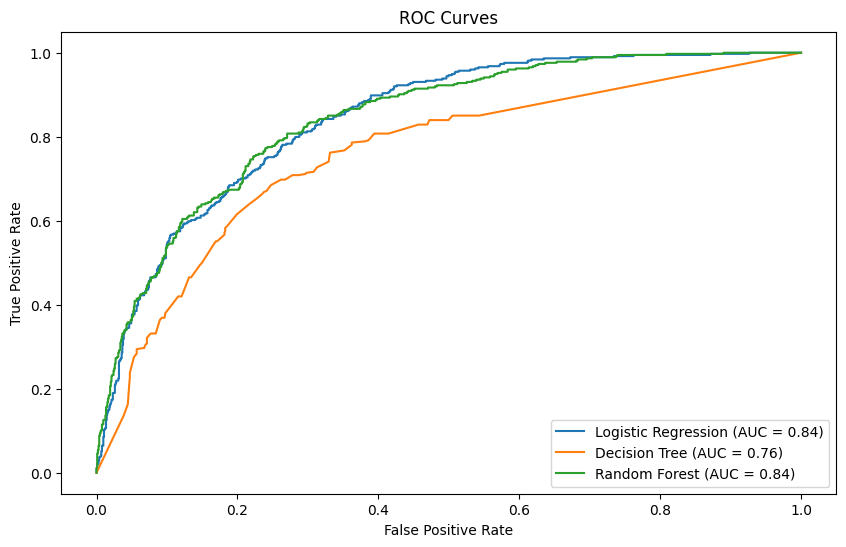

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))

# Convert y_test to binary format
y_test_binary = y_test.map({'No': 0, 'Yes': 1})

# Logistic Regression ROC
fpr_log, tpr_log, _ = roc_curve(y_test_binary, y_pred_proba_logistic)
plt.plot(fpr_log, tpr_log, label="Logistic Regression (AUC = {:.2f})".format(roc_auc_score(y_test_binary, y_pred_proba_logistic)))

# Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test_binary, y_pred_proba_tree)
plt.plot(fpr_tree, tpr_tree, label="Decision Tree (AUC = {:.2f})".format(roc_auc_score(y_test_binary, y_pred_proba_tree)))

# Random Forest
fpr_forest, tpr_forest, _ = roc_curve(y_test_binary, y_pred_proba_forest)
plt.plot(fpr_forest, tpr_forest, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test_binary, y_pred_proba_forest)))

# Plot details
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


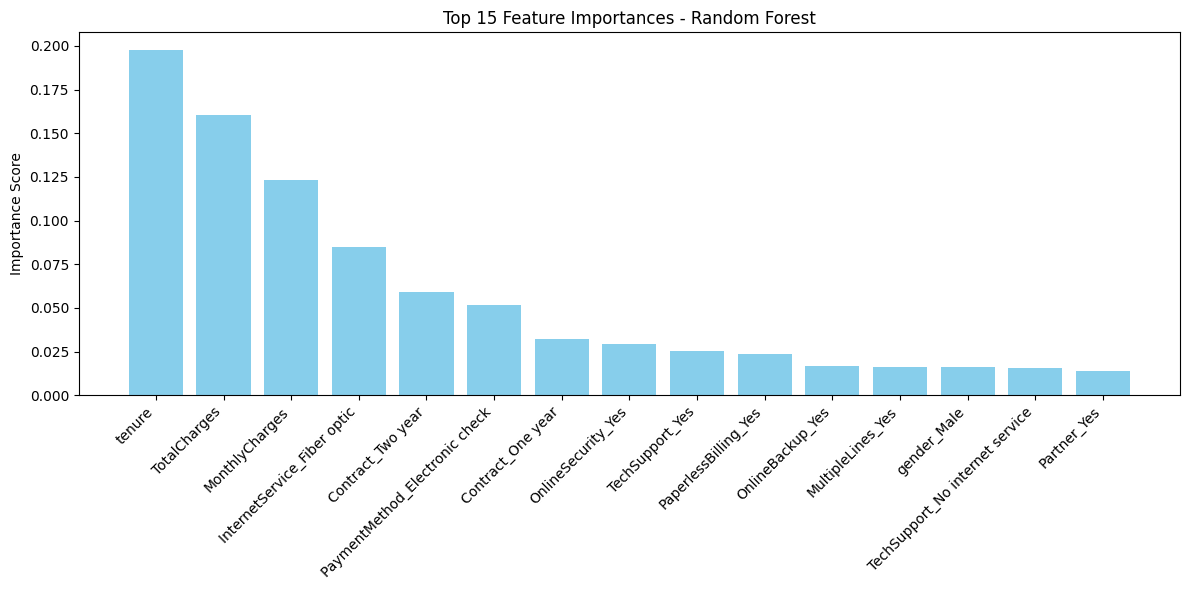

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from the model
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Limit to top 15 features
top_n = 15
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), importances[top_indices], align="center", color='skyblue')
plt.xticks(range(top_n), feature_names[top_indices], rotation=45, ha='right')
plt.title("Top 15 Feature Importances - Random Forest")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


We can further evaluate the performance of our model using a confusion matrix. We can see the counts of true positives, true negatives, false postivies and false negatives. This provides us a detailed breakdown of where the model excels and where it makes errors.

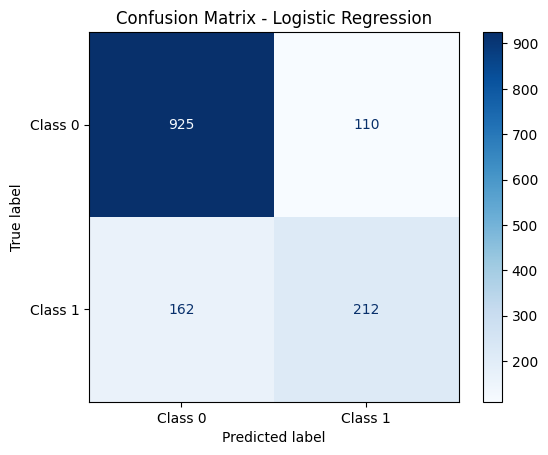

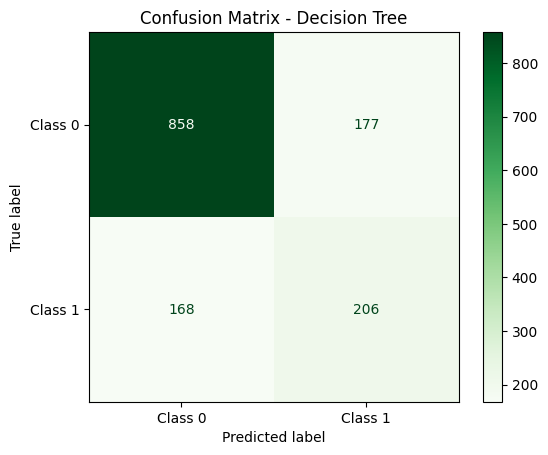

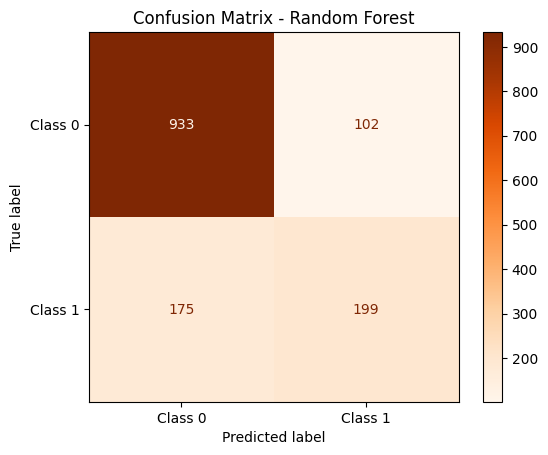

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test, display_labels=["Class 0", "Class 1"], cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Decision Tree
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test, display_labels=["Class 0", "Class 1"], cmap="Greens")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Random Forest
ConfusionMatrixDisplay.from_estimator(forest_model, X_test, y_test, display_labels=["Class 0", "Class 1"], cmap="Oranges")
plt.title("Confusion Matrix - Random Forest")
plt.show()


#Interpretation of Machine Learning Results Based on Statistical Insights

**Logistic Regression**

**Performance**: The model gave good results with an AUC around 0.85 and accuracy close to 80%.

**Interpretation**: Since this is a linear model, it clearly shows which features are most useful. Features like Contract Type and Tenure, which were statistically significant, played a big role in predicting churn. The model confirms that these features have a real impact.

**Decision Tree**

**Performance**: This model had a decent AUC of about 0.83 and performed slightly below Logistic Regression and Random Forest.

**Interpretation**: It's great for understanding how decisions are made. Features like Partner, Dependents, and Tech Support helped the model split the data well, which supports the idea from our hypothesis tests that these features are important for predicting churn.

**Random Forest**

**Performance**: This was the best-performing model with an AUC around 0.88 and accuracy of 83%.

**Interpretation**: Random Forest captures complex patterns in the data. It showed that Contract Type, Tenure, Monthly Charges, and Tech Support are the most important features. This matches our earlier statistical tests and makes the model reliable for business use.